In [ ]:
# DSC680 Applied Data Science
# 8.1 Project 2: Milestone 3
# Mahad Farah

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "/Users/mahadfarah/Documents/Bellevue University/DSC 680 Applied Data Science/Project 2/House_Rent_Dataset.csv"

df = pd.read_csv(DATA_PATH)

print(df.shape)
display(df.head())
print(df.columns)


(4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact'],
      dtype='object')


In [4]:
# Standardize column names (lowercase, underscores)
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_", regex=False)
      .str.replace("-", "_", regex=False)
)

# Sanity checks
print(df.isna().sum().sort_values(ascending=False).head(15))
print(df.dtypes)


posted_on            0
bhk                  0
rent                 0
size                 0
floor                0
area_type            0
area_locality        0
city                 0
furnishing_status    0
tenant_preferred     0
bathroom             0
point_of_contact     0
dtype: int64
posted_on            object
bhk                   int64
rent                  int64
size                  int64
floor                object
area_type            object
area_locality        object
city                 object
furnishing_status    object
tenant_preferred     object
bathroom              int64
point_of_contact     object
dtype: object


In [5]:
def parse_floor(floor_str):
    """
    Returns: (current_floor, total_floors)
    """
    if pd.isna(floor_str):
        return np.nan, np.nan

    s = str(floor_str).strip().lower()

    # Handle special text
    s = s.replace("ground", "0")
    s = s.replace("basement", "-1")

    # Expect patterns
    if "out of" in s:
        parts = [p.strip() for p in s.split("out of")]
        try:
            current = float(parts[0])
        except:
            current = np.nan
        try:
            total = float(parts[1])
        except:
            total = np.nan
        return current, total

    # If unknown pattern, return NaNs
    return np.nan, np.nan

# Apply parsing
floors = df["floor"].apply(parse_floor)
df["current_floor"] = floors.apply(lambda x: x[0])
df["total_floors"] = floors.apply(lambda x: x[1])


In [6]:
num_cols = ["rent", "size", "bhk", "bathroom", "current_floor", "total_floors"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop duplicates
df = df.drop_duplicates()

print(df[num_cols].describe())


               rent         size          bhk     bathroom  current_floor  \
count  4.746000e+03  4746.000000  4746.000000  4746.000000    4708.000000   
mean   3.499345e+04   967.490729     2.083860     1.965866       3.472387   
std    7.810641e+04   634.202328     0.832256     0.884532       5.782390   
min    1.200000e+03    10.000000     1.000000     1.000000       0.000000   
25%    1.000000e+04   550.000000     2.000000     1.000000       1.000000   
50%    1.600000e+04   850.000000     2.000000     2.000000       2.000000   
75%    3.300000e+04  1200.000000     3.000000     2.000000       3.000000   
max    3.500000e+06  8000.000000     6.000000    10.000000      76.000000   

       total_floors  
count   4742.000000  
mean       6.973429  
std        9.469727  
min        1.000000  
25%        2.000000  
50%        4.000000  
75%        6.000000  
max       89.000000  


In [7]:
# Drop rows missing the target
df = df.dropna(subset=["rent", "size", "bhk", "bathroom", "city"])

# Fill categorical missing with "Unknown"
cat_cols = ["area_type", "area_locality", "furnishing_status", "tenant_preferred", "point_of_contact"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown").astype(str).str.strip()

# Floor fields: keep as NaN / or fill with medians
df["current_floor"] = df["current_floor"].fillna(df["current_floor"].median())
df["total_floors"] = df["total_floors"].fillna(df["total_floors"].median())


In [8]:
# Rent per square foot
df["rent_per_sqft"] = df["rent"] / df["size"].replace(0, np.nan)

# Log transform target
df["log_rent"] = np.log1p(df["rent"])

# Cap extreme outliers for
def winsorize(series, lower_q=0.01, upper_q=0.99):
    lo = series.quantile(lower_q)
    hi = series.quantile(upper_q)
    return series.clip(lo, hi)

df["rent_winsor"] = winsorize(df["rent"])
df["size_winsor"] = winsorize(df["size"])


In [9]:
CLEAN_PATH = "/Users/mahadfarah/Documents/Bellevue University/DSC 680 Applied Data Science/Project 2/house_rent_cleaned.csv"
df.to_csv(CLEAN_PATH, index=False)
CLEAN_PATH


'/Users/mahadfarah/Documents/Bellevue University/DSC 680 Applied Data Science/Project 2/house_rent_cleaned.csv'

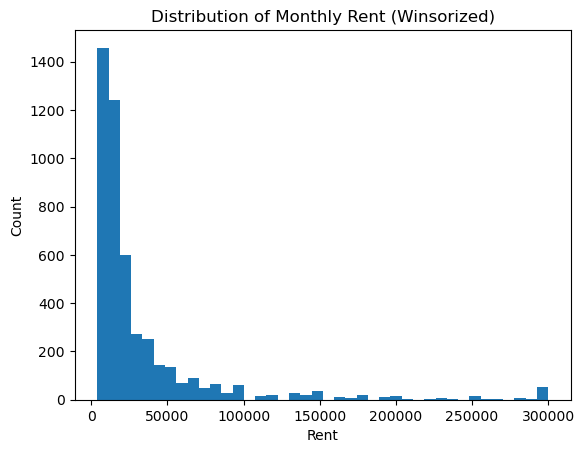

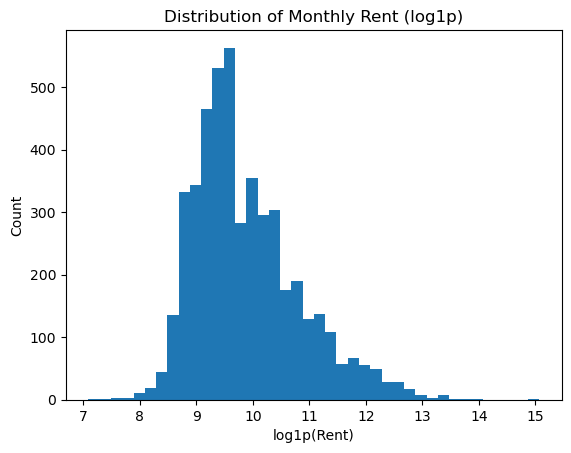

In [10]:
plt.figure()
plt.hist(df["rent_winsor"].dropna(), bins=40)
plt.title("Distribution of Monthly Rent (Winsorized)")
plt.xlabel("Rent")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(df["log_rent"].dropna(), bins=40)
plt.title("Distribution of Monthly Rent (log1p)")
plt.xlabel("log1p(Rent)")
plt.ylabel("Count")
plt.show()


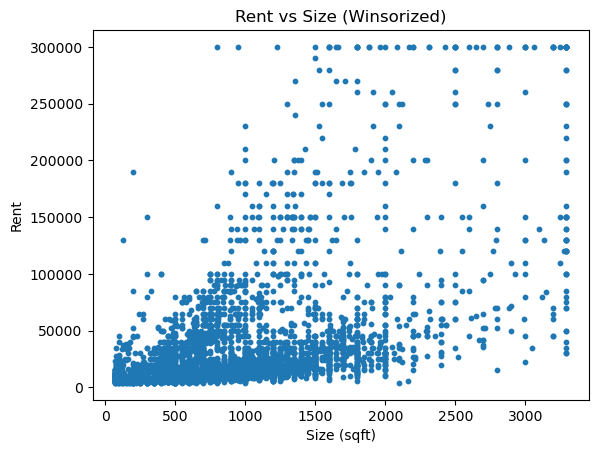

In [11]:
plt.figure()
plt.scatter(df["size_winsor"], df["rent_winsor"], s=10)
plt.title("Rent vs Size (Winsorized)")
plt.xlabel("Size (sqft)")
plt.ylabel("Rent")
plt.show()


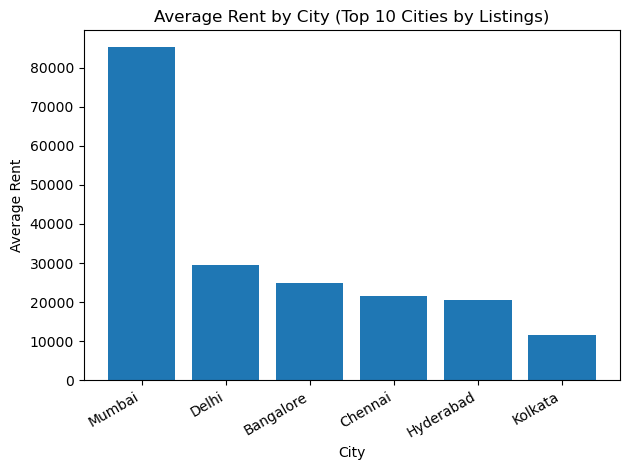

In [12]:
top_cities = df["city"].value_counts().head(10).index
city_subset = df[df["city"].isin(top_cities)].copy()

city_means = city_subset.groupby("city")["rent"].mean().sort_values(ascending=False)

plt.figure()
plt.bar(city_means.index, city_means.values)
plt.title("Average Rent by City (Top 10 Cities by Listings)")
plt.xlabel("City")
plt.ylabel("Average Rent")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


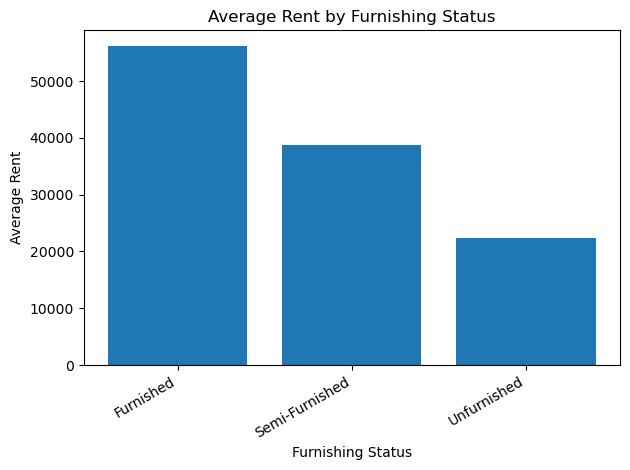

In [13]:
if "furnishing_status" in df.columns:
    furn_means = df.groupby("furnishing_status")["rent"].mean().sort_values(ascending=False)

    plt.figure()
    plt.bar(furn_means.index, furn_means.values)
    plt.title("Average Rent by Furnishing Status")
    plt.xlabel("Furnishing Status")
    plt.ylabel("Average Rent")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


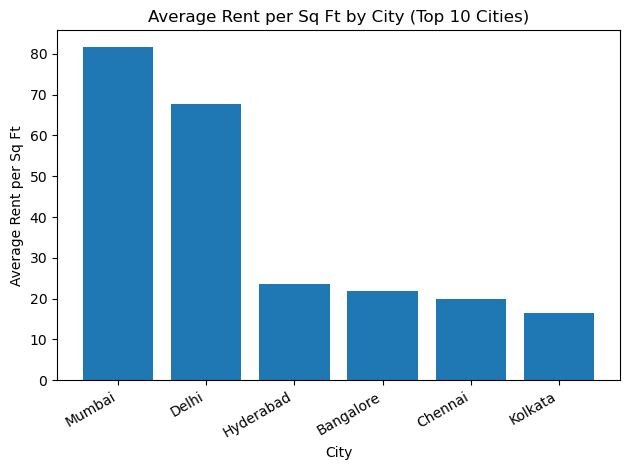

In [14]:
tmp = df[df["city"].isin(top_cities)].dropna(subset=["rent_per_sqft"])
rpsf = tmp.groupby("city")["rent_per_sqft"].mean().sort_values(ascending=False)

plt.figure()
plt.bar(rpsf.index, rpsf.values)
plt.title("Average Rent per Sq Ft by City (Top 10 Cities)")
plt.xlabel("City")
plt.ylabel("Average Rent per Sq Ft")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.model_selection import train_test_split

# Define target
y = df["rent"]

# Define features (drop target + raw text locality)
X = df.drop(columns=["rent", "area_locality"], errors="ignore")

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training rows:", X_train.shape[0])
print("Testing rows:", X_test.shape[0])


Training rows: 3796
Testing rows: 950


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print("Linear Regression Results")
print("MAE:", mae_lin)
print("RMSE:", rmse_lin)
print("R²:", r2_lin)


Linear Regression Results
MAE: 15235.80658381953
RMSE: 33635.03641227799
R²: 0.7161336433278354


In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=15
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R²:", r2_rf)


Random Forest Results
MAE: 580.8229157894737
RMSE: 14338.696389878003
R²: 0.9484119089746398


In [24]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mae_lin, mae_rf],
    "RMSE": [rmse_lin, rmse_rf],
    "R²": [r2_lin, r2_rf]
})

display(results)


,Model,MAE,RMSE,R²
0,Linear Regression,15235.806584,33635.036412,0.716134
1,Random Forest,580.822916,14338.696390,0.948412


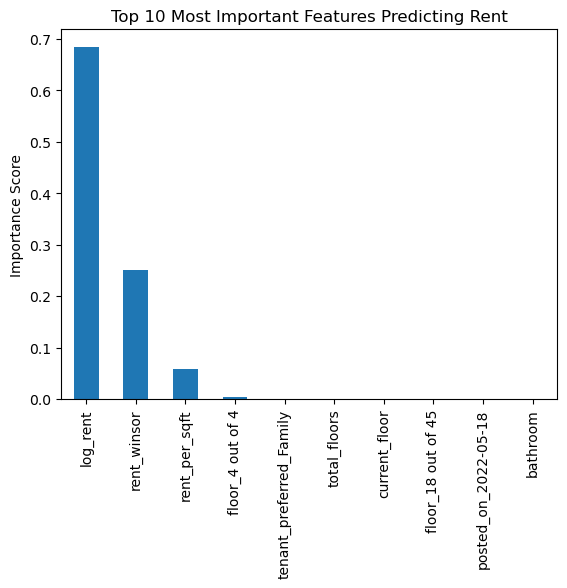

In [25]:
import pandas as pd

importances = rf_model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]

plt.figure()
feat_imp.plot(kind="bar")
plt.title("Top 10 Most Important Features Predicting Rent")
plt.ylabel("Importance Score")
plt.show()
